## LSTM para previsão de séries temporais

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
import torch.nn as nn
import math
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
import netCDF4 as nc
import xarray as xr
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
import matplotlib.pyplot as plt
import pandas as pd
from netuno import SSTHelper

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



### Pegando as temperaturas de um ponto no globo


* P1: Um ponto na região do ENSO;
 -> lat = 20°, lon = -132° (https://www.google.com.br/maps/place/20%C2%B000'00.0%22N+132%C2%B000'00.0%22W/@22.1775213,-151.1364928,3.87z/data=!4m4!3m3!8m2!3d20!4d-132?entry=ttu)

* P2: Um ponto na costa do Chile (Corrente de Humboldt);
 -> lat = -22°, lon = -72° (https://www.google.com.br/maps/place/22%C2%B000'00.0%22S+72%C2%B000'00.0%22W/@-21.7898533,-87.474343,4.04z/data=!4m4!3m3!8m2!3d-22!4d-72?entry=ttu)

* P3: Um ponto no meio do Mediterrâneo;
 -> lat = 36°, lon = 18° (https://www.google.com.br/maps/place/36%C2%B000'00.0%22N+18%C2%B000'00.0%22E/@36.0000043,17.9974251,17z/data=!3m1!4b1!4m4!3m3!8m2!3d36!4d18?entry=ttu)

* P4: Um ponto no meio do Atlântico;
 -> lat = 0°, lon = -22° (https://www.google.com.br/maps/place/0%C2%B000'00.0%22N+22%C2%B000'00.0%22W/@-11.0144452,-50.6148726,3z/data=!4m3!3m2!8m1!4d-22?entry=ttu)

* P5: Um ponto no extremo Índico (ponto de maior latitude, temperaturas mais baixas)
 -> lat = -56°, lon = 80° (https://www.google.com.br/maps/place/56%C2%B000'00.0%22S+80%C2%B000'00.0%22E/@-36.027701,54.6888129,3z/data=!4m4!3m3!8m2!3d-56!4d80?entry=ttu)

In [3]:
fp = '../dados/sst.mnmean.nc'
ds = SSTHelper.load_dataset(fp)

In [4]:
df = SSTHelper.load_dataframe(ds)

In [5]:
p1_enso   = SSTHelper.get_sst_series_default(df,  20  ,   -132)
p2_chile  = SSTHelper.get_sst_series_default(df, -22  ,    -72)
p3_medit  = SSTHelper.get_sst_series_default(df,  36  ,    18)
p4_atlan  = SSTHelper.get_sst_series_default(df,  0   ,   -22)
p5_indic  = SSTHelper.get_sst_series_default(df,  -56 ,    80)

In [6]:
default_start = 2005

In [7]:
p1_enso  = p1_enso.reset_index().drop(['lat','lon'], axis=1).set_index('time')
p2_chile = p2_chile.reset_index().drop(['lat','lon'], axis=1).set_index('time')
p3_medit = p3_medit.reset_index().drop(['lat','lon'], axis=1).set_index('time')
p4_atlan = p4_atlan.reset_index().drop(['lat','lon'], axis=1).set_index('time')
p5_indic = p5_indic.reset_index().drop(['lat','lon'], axis=1).set_index('time')

In [8]:
scaler1 = MinMaxScaler(feature_range=(-1, 1))
p1_enso['sst'] = scaler1.fit_transform(p1_enso['sst'].values.reshape(-1, 1))
scaler2 = MinMaxScaler(feature_range=(-1, 1))
p2_chile['sst'] = scaler2.fit_transform(p2_chile['sst'].values.reshape(-1, 1))
scaler3 = MinMaxScaler(feature_range=(-1, 1))
p3_medit['sst'] = scaler3.fit_transform(p3_medit['sst'].values.reshape(-1, 1))
scaler4 = MinMaxScaler(feature_range=(-1, 1))
p4_atlan['sst'] = scaler4.fit_transform(p4_atlan['sst'].values.reshape(-1, 1))
scaler5 = MinMaxScaler(feature_range=(-1, 1))
p5_indic['sst'] = scaler5.fit_transform(p5_indic['sst'].values.reshape(-1, 1))

In [9]:
from netuno.lstm_functions import *

Train score: 0.47592181482096285 RMSE
Test score: 0.5358488370103165 RMSE
Train score: 0.015784322910433572 MAPE
Test score: 0.019260372820423744 MAPE


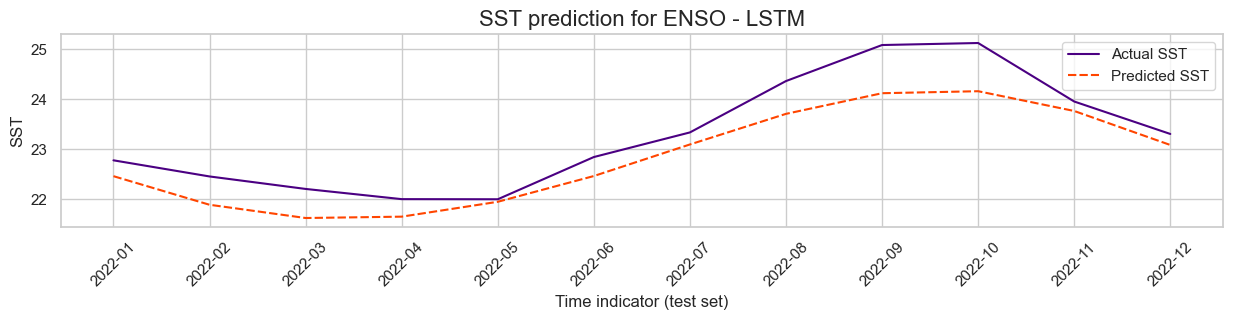

In [11]:
name = 'ENSO - LSTM'

X_train, y_train, X_test, y_test = create_split_data(ts=p1_enso, lookback=12, test_start=default_start)
model = LSTM_base(input_dim=1, hidden_size=64, num_layers=1, output_dim=1)

# funcao perda: MSE Loss
loss_function = nn.MSELoss()

# otimizadorAdam com lr=.005
optimizer = torch.optim.Adam(model.parameters(), lr=.002)

history_train, y_pred_train, y_pred_test = training_and_evaluate(model=model,
                                                                 epochs=100,
                                                                 loss_function=loss_function,
                                                                 optimizer=optimizer,
                                                                 X_train=X_train,
                                                                 y_train=y_train,
                                                                 X_test=X_test,
                                                                 verbose=False)

current_view = X_test[0:1]
y_pred_blind = []

for i in range(12):
    with torch.no_grad():
        y_pred = model.forward(current_view)
        current_view = torch.cat([current_view.reshape(-1), y_pred.reshape(-1)])[1:].reshape(1,11,1)
        y_pred_blind.append(y_pred)

model_performance(scaler1, y_train, y_pred_train, y_test[:12], torch.cat(y_pred_blind), name, 'LSTM')


Train score: 0.708571320421462 RMSE
Test score: 0.5795056480636792 RMSE
Train score: 0.029100315647381213 MAPE
Test score: 0.027726104279428263 MAPE


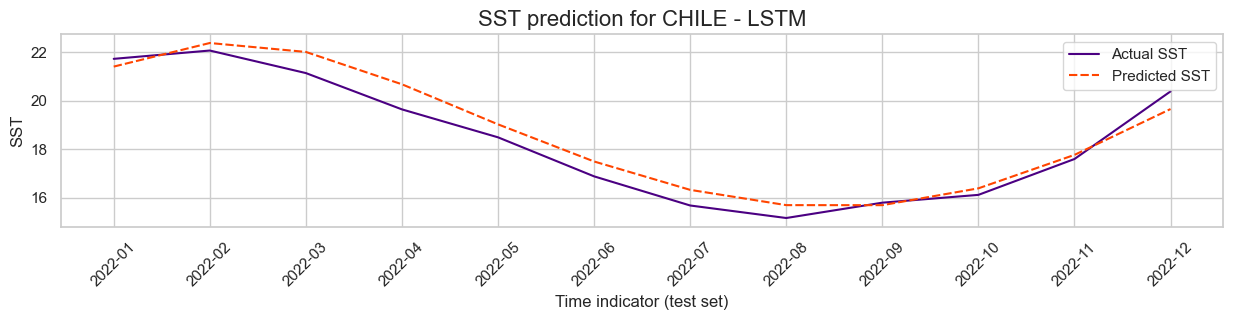

In [12]:
name = 'CHILE - LSTM'

X_train, y_train, X_test, y_test = create_split_data(ts=p2_chile, lookback=12, test_start=default_start)
model = LSTM_base(input_dim=1, hidden_size=64, num_layers=1, output_dim=1)

# funcao perda: MSE Loss
loss_function = nn.MSELoss()

# otimizadorAdam com lr=.005
optimizer = torch.optim.Adam(model.parameters(), lr=.002)

history_train, y_pred_train, y_pred_test = training_and_evaluate(model=model,
                                                                 epochs=100,
                                                                 loss_function=loss_function,
                                                                 optimizer=optimizer,
                                                                 X_train=X_train,
                                                                 y_train=y_train,
                                                                 X_test=X_test,
                                                                 verbose=False)

current_view = X_test[0:1]
y_pred_blind = []

for i in range(12):
    with torch.no_grad():
        y_pred = model.forward(current_view)
        current_view = torch.cat([current_view.reshape(-1), y_pred.reshape(-1)])[1:].reshape(1,11,1)
        y_pred_blind.append(y_pred)

model_performance(scaler2, y_train, y_pred_train, y_test[:12], torch.cat(y_pred_blind), name, 'LSTM')


Train score: 0.750144816674916 RMSE
Test score: 1.4861609407245933 RMSE
Train score: 0.028237874947897004 MAPE
Test score: 0.05981553076799075 MAPE


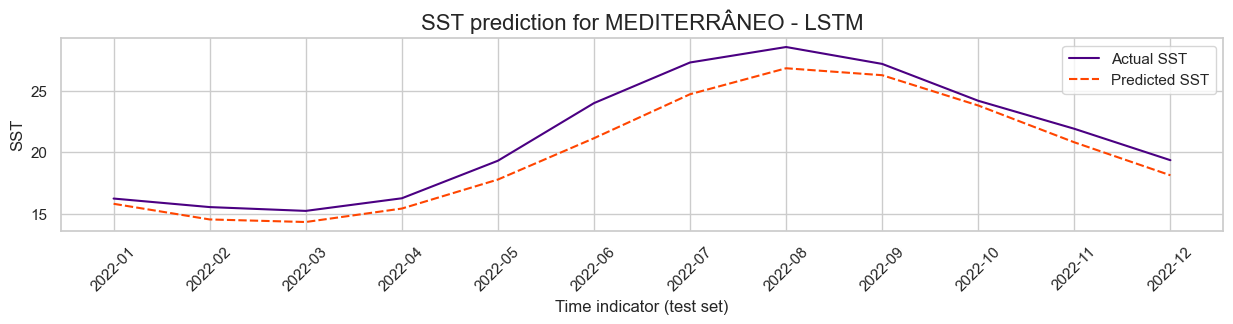

In [13]:
name = 'MEDITERRÂNEO - LSTM'

X_train, y_train, X_test, y_test = create_split_data(ts=p3_medit, lookback=12, test_start=default_start)
model = LSTM_base(input_dim=1, hidden_size=64, num_layers=1, output_dim=1)

# funcao perda: MSE Loss
loss_function = nn.MSELoss()

# otimizadorAdam com lr=.005
optimizer = torch.optim.Adam(model.parameters(), lr=.002)

history_train, y_pred_train, y_pred_test = training_and_evaluate(model=model,
                                                                 epochs=100,
                                                                 loss_function=loss_function,
                                                                 optimizer=optimizer,
                                                                 X_train=X_train,
                                                                 y_train=y_train,
                                                                 X_test=X_test,
                                                                 verbose=False)

current_view = X_test[0:1]
y_pred_blind = []

for i in range(12):
    with torch.no_grad():
        y_pred = model.forward(current_view)
        current_view = torch.cat([current_view.reshape(-1), y_pred.reshape(-1)])[1:].reshape(1,11,1)
        y_pred_blind.append(y_pred)

model_performance(scaler3, y_train, y_pred_train, y_test[:12], torch.cat(y_pred_blind), name, 'LSTM')


Train score: 0.3974060213705328 RMSE
Test score: 0.6300877482613308 RMSE
Train score: 0.011547854060299527 MAPE
Test score: 0.019937105016772115 MAPE


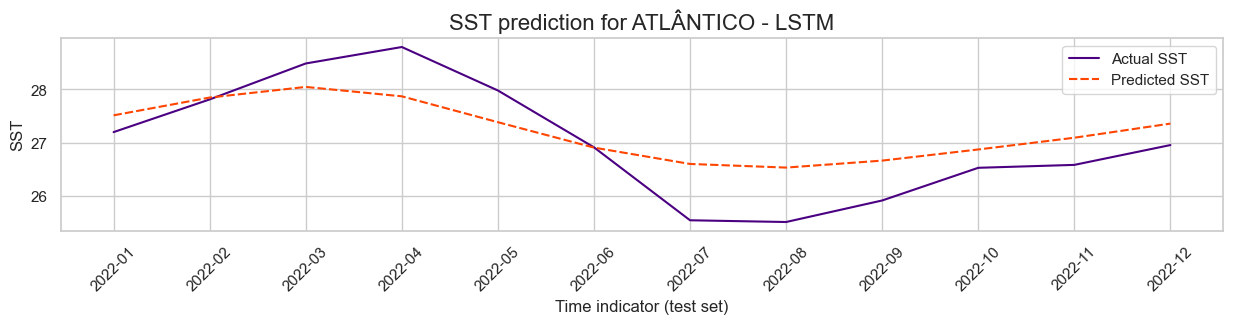

In [14]:
name = 'ATLÂNTICO - LSTM'

X_train, y_train, X_test, y_test = create_split_data(ts=p4_atlan, lookback=12, test_start=default_start)
model = LSTM_base(input_dim=1, hidden_size=64, num_layers=1, output_dim=1)

# funcao perda: MSE Loss
loss_function = nn.MSELoss()

# otimizadorAdam com lr=.005
optimizer = torch.optim.Adam(model.parameters(), lr=.002)

history_train, y_pred_train, y_pred_test = training_and_evaluate(model=model,
                                                                 epochs=100,
                                                                 loss_function=loss_function,
                                                                 optimizer=optimizer,
                                                                 X_train=X_train,
                                                                 y_train=y_train,
                                                                 X_test=X_test,
                                                                 verbose=False)

current_view = X_test[0:1]
y_pred_blind = []

for i in range(12):
    with torch.no_grad():
        y_pred = model.forward(current_view)
        current_view = torch.cat([current_view.reshape(-1), y_pred.reshape(-1)])[1:].reshape(1,11,1)
        y_pred_blind.append(y_pred)

model_performance(scaler4, y_train, y_pred_train, y_test[:12], torch.cat(y_pred_blind), name, 'LSTM')


Train score: 0.21114428888487508 RMSE
Test score: 0.19230394038358473 RMSE
Train score: 0.7918128656961747 MAPE
Test score: 0.38263287896551157 MAPE


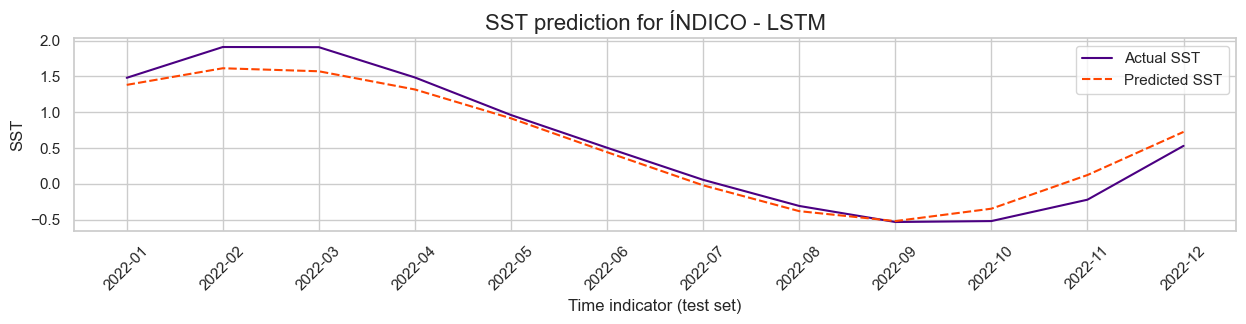

In [17]:
name = 'ÍNDICO - LSTM'

X_train, y_train, X_test, y_test = create_split_data(ts=p5_indic, lookback=12, test_start=default_start)
model = LSTM_base(input_dim=1, hidden_size=64, num_layers=1, output_dim=1)

# funcao perda: MSE Loss
loss_function = nn.MSELoss()

# otimizadorAdam com lr=.005
optimizer = torch.optim.Adam(model.parameters(), lr=.002)

history_train, y_pred_train, y_pred_test = training_and_evaluate(model=model,
                                                                 epochs=100,
                                                                 loss_function=loss_function,
                                                                 optimizer=optimizer,
                                                                 X_train=X_train,
                                                                 y_train=y_train,
                                                                 X_test=X_test,
                                                                 verbose=False)

current_view = X_test[0:1]
y_pred_blind = []

for i in range(12):
    with torch.no_grad():
        y_pred = model.forward(current_view)
        current_view = torch.cat([current_view.reshape(-1), y_pred.reshape(-1)])[1:].reshape(1,11,1)
        y_pred_blind.append(y_pred)

model_performance(scaler5, y_train, y_pred_train, y_test[:12], torch.cat(y_pred_blind), name, 'LSTM')
